In [1]:
SMALL_SIZE, MEDIUM_SIZE = 9, 12
PROJECT_PATH = "/Users/donghur/Desktop/Research/Murthy/BM_GPU"

In [2]:
import sys
import numpy as np
from glob import glob
import random, matplotlib
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

sys.path.append(PROJECT_PATH)
from utils.data import Dataset


In [3]:
import utils.figure as ufigure
%load_ext autoreload
%autoreload 1
%aimport utils.data
%aimport utils.figure

In [4]:
Data = Dataset(PROJECT_PATH, 'final')
Data.load_data()

Loading INFO.yaml ...
Finished loading INFO
Loading config.yaml ...
Finished loading config


100%|██████████| 141/141 [00:33<00:00,  4.18it/s]


In [17]:
# configuration
INFO = Data.info
INFO_values = Data.info_values
config = Data.config
skeleton = config['skeleton']
skeleton_color= config['skeleton_color']

# features
bp = Data.data_obj['bodypoints']
rot_bp = Data.data_obj['rotated_bodypoints']
angles = Data.data_obj['angles']
limbs = Data.data_obj['limbs']
angle_power = Data.data_obj['angle_power']
limb_power = Data.data_obj['limb_power']

# embeddings
all_embed = Data.data_obj['all_embeddings']
all_postural_embed = Data.data_obj['all_postural_embeddings']
all_kinematic_embed = Data.data_obj['all_kinematic_embeddings']

all_clusters = Data.data_obj['cluster']
num_clusters = int(np.max(all_cluster)+1)

In [66]:
num_fr,_ = all_embed.shape
nan_fr, nan_dim = np.where( np.isnan(all_embed) )
unique_nan_fr = np.unique(nan_fr)

good_fr = np.array([True]*num_fr)
good_fr[unique_nan_fr] = False

In [75]:
good_embedding = all_embed[good_fr] 

In [79]:
np.savetxt("embedding.csv", good_embedding, delimiter=",")

<hr><hr>

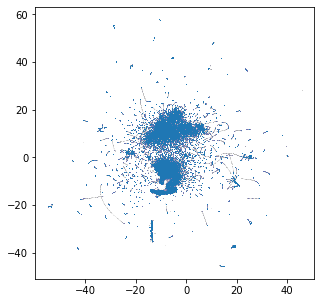

In [6]:
fig_all_embed, ax_all_embed = plt.subplots(1,1,figsize=(5,5))
ax_all_embed.scatter(all_embed[:,0], all_embed[:,1], s=1, alpha=0.005)
plt.show()

<hr><hr>

In [7]:
# Global parameter for the rest of the embeddings
ax_x_length = np.diff(ax_all_embed.get_xlim())[0]
ax_y_length = np.diff(ax_all_embed.get_ylim())[0]

def fix_aspect_ratio(xlim, ylim):
    d = np.diff(xlim)[0]*ax_y_length/ax_x_length - np.diff(ylim)[0]
    return xlim, (ylim[0]-d/2, ylim[1]+d/2)

def plot_embedding(embed, xlim, ylim, frac_pts=1/3, scatter_s=1, scatter_alpha=0.04, kde_gridsize=200):
    num_fr = len(embed)
    idx = random.choices(np.arange(num_fr), k=int(num_fr*frac_pts))
    
    # Scatter Plot
    fig, ax = plt.subplots(1,2,figsize=(20,10))
    ax[0].scatter(embed[idx,0], embed[idx,1], s=scatter_s, alpha=scatter_alpha)
    ax[0].set(xlabel='UMAP C1', ylabel='UMAP C2', title="All Postural Features Embedding", xlim=xlim,ylim=ylim)

    # Density Plot
    sns.kdeplot(x=embed[idx,0], y=embed[idx,1], 
                shade=True, thresh=0, gridsize=kde_gridsize, bw_adjust=0.3,
                levels=100, cmap='viridis',
                cbar=False, ax=ax[1])
    ax[1].set(xlabel='UMAP C1', ylabel='UMAP C2', title="All Postural Features Embedding", facecolor='#440054', 
                        xlim=xlim ,ylim=ylim)
    plt.show()

In [55]:
def plot_HDBSCAN(ax, embed, labels, color_palette, marker_size=1, alpha=0.005, xlim=None, ylim=None, toggle_numbering=False):
    num_clusters = int(np.max(labels)+1)
    outlier_pts = np.where(labels== -1)[0]
    labeled_pts = np.where(labels!= -1)[0]

    # cmap: coloring
    cluster_colors = np.array([color_palette[int(x)] if int(x) >= 0
                      else (0.5, 0.5, 0.5)
                      for x in labels])

    # cluster colors
    ax.scatter(embed[outlier_pts,0], embed[outlier_pts,1], 
               c="gray", s=marker_size, alpha=alpha)
    ax.scatter(embed[labeled_pts,0], embed[labeled_pts,1], 
               c=cluster_colors[labeled_pts], s=marker_size, alpha=alpha)
    ax.set(xlabel='UMAP C1', ylabel='UMAP C2', title="All Postural Features HDBSCAN Clusters")
    
    # numbering
    if toggle_numbering:
        cluster_mean = []
        for i in tqdm(range(num_clusters)):
            cluster_mean.append(np.mean(embed[labels==i,:], axis=0).tolist())
        cluster_mean = np.array(cluster_mean)
    
    
    
    if (xlim!=None) | (ylim!=None):
        ax.set(xlim=xlim, ylim=ylim)
        
        # plot numbering
        x_cond = (cluster_mean[:,0]>xlim[0]) & (cluster_mean[:,0]<xlim[1])
        y_cond = (cluster_mean[:,1]>ylim[0]) & (cluster_mean[:,1]<ylim[1])
        clust_numb_disp = np.where(x_cond&y_cond)[0]
        for i in tqdm(clust_numb_disp):
            ax.annotate(i, cluster_mean[i], fontsize=10, fontweight='bold')
    return cluster_mean

In [14]:
import seaborn as sns
from sklearn.utils import shuffle

color_palette = sns.color_palette('rainbow', int(num_clusters))
color_palette = shuffle(color_palette, random_state=1)

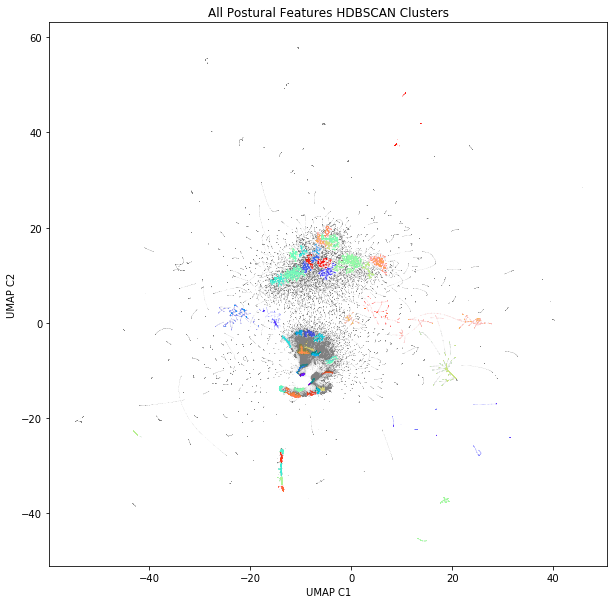

In [23]:
fig, ax = plt.subplots(figsize=(10,10))
plot_HDBSCAN(ax, all_embed, all_clusters, color_palette, marker_size=0.01, alpha=0.02)
plt.show()

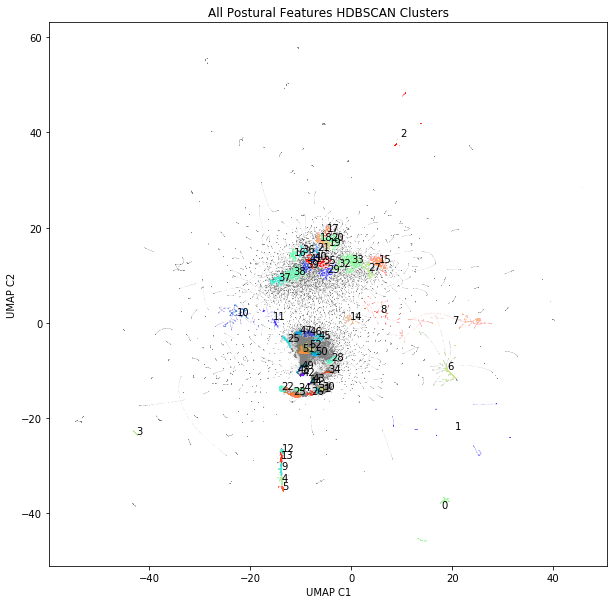

In [30]:
fig, ax = plt.subplots(figsize=(10,10))
plot_HDBSCAN(ax, all_embed, all_clusters, color_palette, marker_size=0.01, alpha=0.02, toggle_numbering=True)
plt.show()

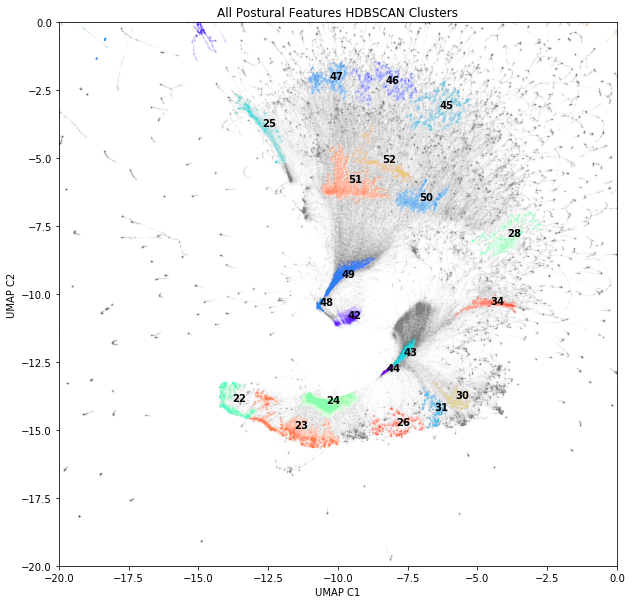

In [56]:
fig, ax = plt.subplots(figsize=(10,10))
xlim, ylim = fix_aspect_ratio(xlim=(-20,0), ylim=(-20,0))
cluster_mean = plot_HDBSCAN(ax, all_embed, all_clusters, color_palette, marker_size=0.5, alpha=0.02, toggle_numbering=True, 
             xlim=xlim, ylim=ylim)
plt.show()

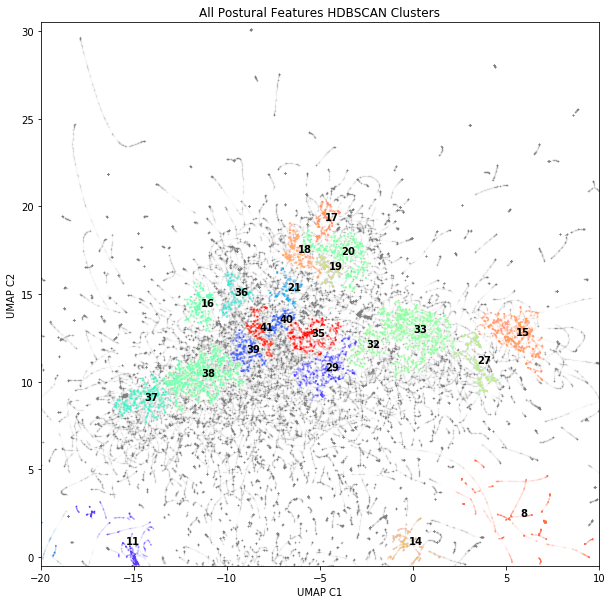

In [58]:
fig, ax = plt.subplots(figsize=(10,10))
xlim, ylim = fix_aspect_ratio(xlim=(-20,10), ylim=(0,30))
cluster_mean = plot_HDBSCAN(ax, all_embed, all_clusters, color_palette, marker_size=0.5, alpha=0.02, toggle_numbering=True, 
             xlim=xlim, ylim=ylim)
plt.show()

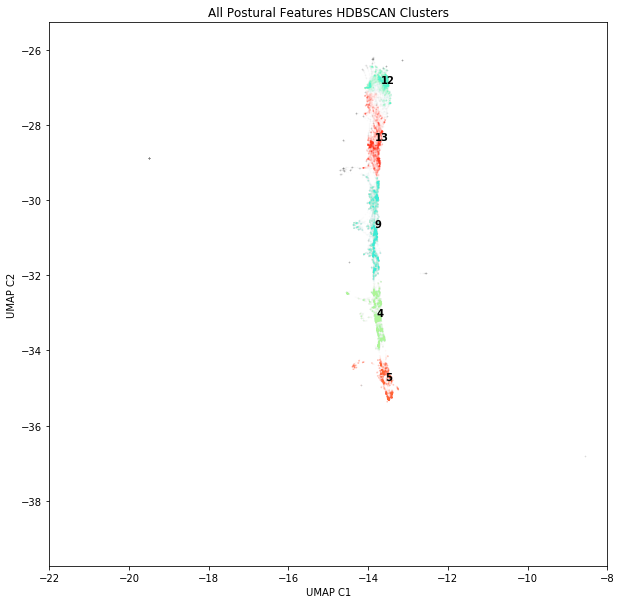

In [61]:
fig, ax = plt.subplots(figsize=(10,10))
xlim, ylim = fix_aspect_ratio(xlim=(-22,-8), ylim=(-45,-20))
cluster_mean = plot_HDBSCAN(ax, all_embed, all_clusters, color_palette, marker_size=0.5, alpha=0.02, toggle_numbering=True, 
             xlim=xlim, ylim=ylim)
plt.show()